In [36]:
# Descomentar esta línea si se quiere ejecutar en local
!pip install yfinance

In [37]:
# Importando librerías
import numpy as np
import matplotlib. pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import datetime as dt
import seaborn as sns
import matplotlib.dates as mdates

## Funciones

In [38]:
def GetStockDataByTicker(tickerSymbol, start_date, end_date):
    # Descarga de datos
    tickerData = yf.Ticker(tickerSymbol)

    # Obtiene el precio histórico de la compañía
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date, auto_adjust=False)
    tickerDf = tickerDf.dropna().sort_index(ascending=False)

    # Se modifica el valor 'Adj Close' teniendo en cuenta los Splits y Dividendos de cada compañía, y se crea el valor 'Adj Open'
    tickerDf = ChangeStockSplit(tickerDf)

    # Se calculan las medias de las últimas 20-50-100-200 semanas con este nuevo valor.
    SMA_20 = 20
    SMA_50 = 50
    SMA_100 = 100
    SMA_200 = 200
    SMAs=[SMA_20, SMA_50, SMA_100, SMA_200]
    tickerDf = CalculateSMA(tickerDf, SMAs)

    # Se calcula la EMA de los últimos 10 días
    tickerDf = CalculateEMA(tickerDf, 10)

    return tickerDf

In [39]:
def GetStockInformationByTicker(tickerSymbol, start_date, end_date):
    tickerDf = GetStockDataByTicker(tickerSymbol, start_date, end_date)

    companyInformation = pd.DataFrame(columns=['Ticker', 'Short Name', 'Sector', 'Industry', 'Recommendation', 'Recommendation Mean', 'Target Low Price', 'Target High Price', 'Target Mean Price', 'Current Price', '%', 'Volume', 'Average Volume', 'EBITDA', 'EBITDA Margins', 'Fecha Actualización', '52 Week Change', 'SMA20', 'SMA50', 'SMA100', 'SMA200'])

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)
    companyList = {'Ticker': tickerData.info['symbol'], 
                'Short Name': tickerData.info['shortName'], 
                'Sector': tickerData.info['sector'], 
                'Industry': tickerData.info['industry'], 
                'Recommendation': tickerData.info['recommendationKey'], 
                'Recommendation Mean': tickerData.info['recommendationMean'],
                'Target Low Price': tickerData.info['targetLowPrice'],
                'Target High Price': tickerData.info['targetHighPrice'],
                'Target Mean Price': tickerData.info['targetMeanPrice'], 
                'Current Price': tickerData.info['currentPrice'],
                '%': 0,
                'Volume': tickerData.info['volume'], 
                'Average Volume': tickerData.info['averageVolume'],
                'EBITDA': tickerData.info['ebitda'],
                'EBITDA Margins': tickerData.info['ebitdaMargins'],
                'Fecha Actualización': datetime.now().strftime('%Y-%m-%d %H:%M'),
                '52 Week Change': tickerData.info['52WeekChange'],
                'SMA20': round(tickerDf.iloc[-1]['SMA_20'], 2),
                'SMA50': round(tickerDf.iloc[-1]['SMA_50'], 2),
                'SMA100': round(tickerDf.iloc[-1]['SMA_100'], 2),
                'SMA200': round(tickerDf.iloc[-1]['SMA_200'], 2),
                'EMA10': round(tickerDf.iloc[-1]['EMA_10'], 2)}
    companyInformation = companyInformation.append(companyList, ignore_index=True)

    return companyInformation

In [40]:
def CalculateSMA(data, SMAs):
    data = data.sort_index(ascending=True)
    for i in SMAs:
        data["SMA_" + str(i)] = data['Adj Close'].rolling(window=i).mean()
    
    return data 

In [41]:
def CalculateEMA(data, days):
    data['EMA_' + str(days)] = data['Adj Close'].ewm(span=days, adjust=False).mean()

    return data

In [42]:
def Graph_StockEvolutionByTime(tickerSymbol, stockEvolution, last_days=0):
    if last_days != 0:
        stockEvolution = stockEvolution.tail(last_days)
        
    fig, ax = plt.subplots(figsize=(14,8))

    import matplotlib.dates as mdates
    my_year_month_fmt = mdates.DateFormatter('%m-%Y')

    ax.plot(stockEvolution['Adj Close'], label='Price')
    
    # SMA Representation
    ax.plot(stockEvolution['SMA_20'], label = '20-days SMA')
    ax.plot(stockEvolution['SMA_50'], label = '50-days SMA')
    ax.plot(stockEvolution['SMA_100'], label = '100-days SMA')
    ax.plot(stockEvolution['SMA_200'], label = '200-days SMA')

    # EMA Representation
    ax.plot(stockEvolution['EMA_10'], label = '10-days EMA')

    ax.legend(loc='best')
    ax.set_ylabel('Precio en $')
    ax.set_xlabel('Evolución en el Tiempo')
    title = ('Evolución ajustada de ' + tickerSymbol + ' en el tiempo')
    ax.set_title(title)
    ax.xaxis.set_major_formatter(my_year_month_fmt)

In [43]:
def ChangeStockSplit(adj_TickerDf):
    adj_TickerDf = adj_TickerDf.sort_index(ascending=False)
    new_split = 1
    for i in range(len(adj_TickerDf)-1):
        first_change = False;
        div = adj_TickerDf['Adj Close'].iloc[i+1] / adj_TickerDf['Adj Close'].iloc[i]

        # Se calculan los nuevos valores
        adj_TickerDf.loc[adj_TickerDf.index[i], 'Adj Open'] = adj_TickerDf['Open'].iloc[i] / new_split
        adj_TickerDf.loc[adj_TickerDf.index[i], 'Adj Close'] = adj_TickerDf['Adj Close'].iloc[i] / new_split

        if (round(div) > 1):
            new_split = round(div)
    
    # Se cambia el valor del último registro ya que no se está recorriendo en el bucle
    adj_TickerDf.loc[adj_TickerDf.index[-1], 'Adj Open'] = adj_TickerDf['Open'].iloc[-1] / new_split
    adj_TickerDf.loc[adj_TickerDf.index[-1], 'Adj Close'] = adj_TickerDf['Close'].iloc[-1] / new_split

    return adj_TickerDf

In [44]:
def Graph_StockEvolutionWithHighLowValues(tickerDf, tickerSymbol):
    price_close = pd.Series(tickerDf['Adj Close'].values, index=tickerDf.index)
    close_ma = price_close.rolling(2).mean()
    close_mstd = price_close.rolling(2).std()
    price_open = pd.Series(tickerDf['Adj Open'].values, index=tickerDf.index)
    open_ma = price_open.rolling(2).mean()
    open_mstd = price_open.rolling(2).std()

    fig, axs = plt.subplots(1, 2, figsize=(18,8), sharey=True)

    for nn, ax in enumerate(axs):
        prices = [price_close, price_open]
        colors = ["cornflowerblue", "forestgreen"]
        means = [close_ma, open_ma]
        stds = [close_mstd, open_mstd]
        
        locator = mdates.AutoDateLocator(minticks=3, maxticks=20)
        formatter = mdates.ConciseDateFormatter(locator)
        
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_xlabel("Date")
        ax.plot(prices[nn].index, prices[nn], colors[nn])
        ax.fill_between(stds[nn].index, means[nn] - 2 * stds[nn], means[nn] + 2 * stds[nn], color="grey", alpha=0.3)

    axs[0].set_ylabel("Precio de Cierre")
    axs[1].set_ylabel("Precio de Apertura")

    title = ("Desviación típica de los precios de Apertura y Cierre en el último año para la compañía " + tickerSymbol)
    fig.suptitle(title)

## Descarga de Datos

In [45]:
tickerSymbol = 'AAPL'

# Obtenemos los datos desde el día actual hasta hace 5 años
five_years_ago = datetime.now() - relativedelta(years=5)
start_date = five_years_ago.strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

tickerDf = GetStockDataByTicker(tickerSymbol, start_date, end_date)

In [46]:
GetStockInformationByTicker(tickerSymbol, start_date, end_date)

,Ticker,Short Name,Sector,Industry,Recommendation,Recommendation Mean,Target Low Price,Target High Price,Target Mean Price,Current Price,%,Volume,Average Volume,EBITDA,EBITDA Margins,Fecha Actualización,52 Week Change,SMA20,SMA50,SMA100,SMA200,EMA10
0,AAPL,Apple Inc.,Technology,Consumer Electronics,buy,1.8,128.01,210,175.76,177.57,0,64062281,88976285,120233000960,0.32867,2022-01-02 17:21,0.372151,174.48,162.05,154.51,143.66,176.74


## Gráficas de la acción

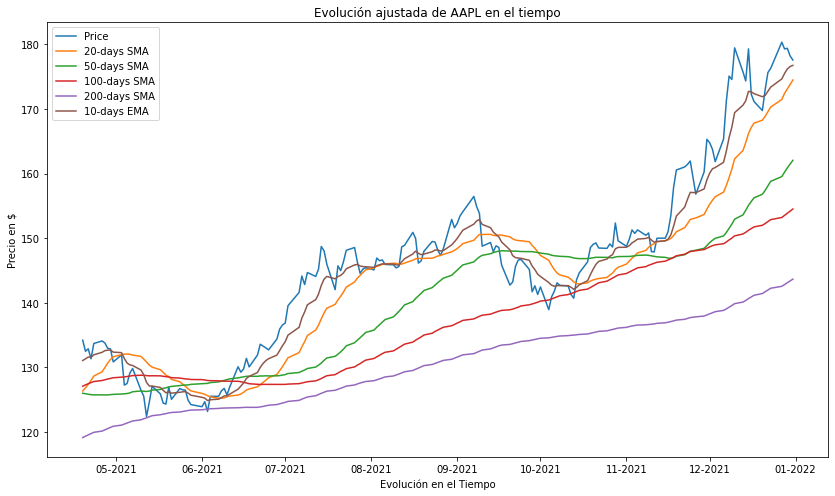

In [50]:
Graph_StockEvolutionByTime(tickerSymbol, tickerDf, 180)

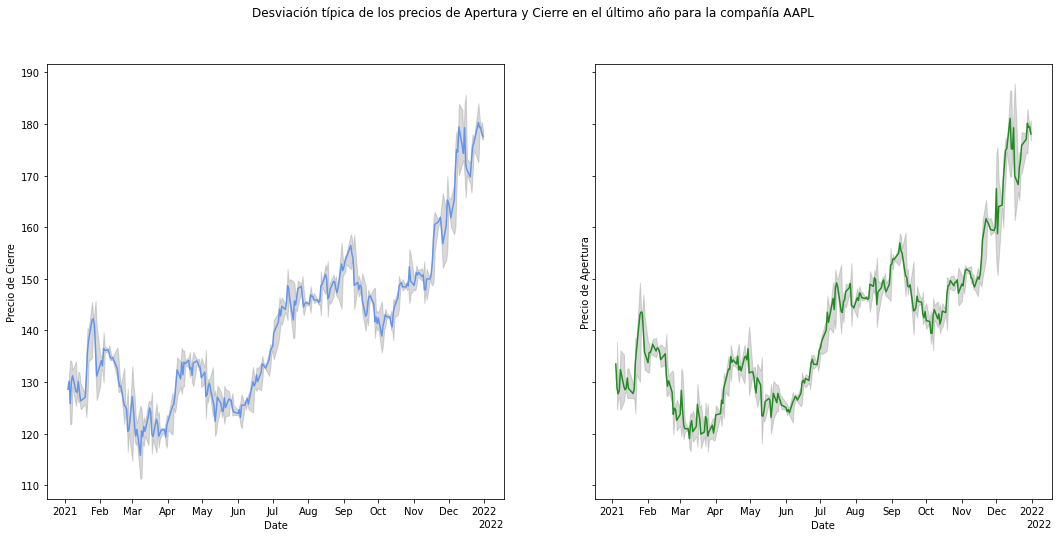

In [48]:
one_year_ago_df = tickerDf.loc[tickerDf.index >= datetime.now() - relativedelta(years=1)]
Graph_StockEvolutionWithHighLowValues(one_year_ago_df, tickerSymbol)

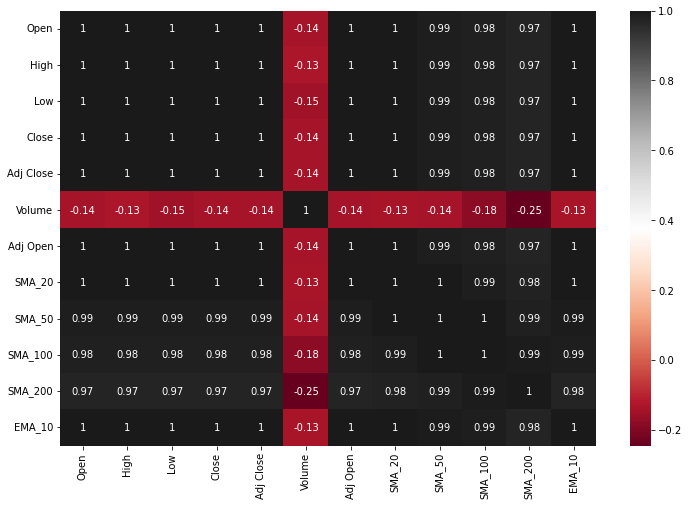

In [49]:
corr = tickerDf.drop(['Dividends', 'Stock Splits'], axis=1)
plt.subplots(figsize=(12,8))
sns.heatmap(corr.corr(), cmap = 'RdGy', annot=True)